In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from matplotlib.patches import Rectangle
import cv2
import ipywidgets as widgets
import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter
import gc

In [2]:
# cap = cv2.VideoCapture("./TRIM_Archana_ELAV_01_Feb-20_12-17.avi")
# number = 302

# cap = cv2.VideoCapture("./60fps/TRIM_3_jag_Set2_Apr-04_13-13.avi")
# number = 861

# cap = cv2.VideoCapture("./60fps/TRIM_4_jag_Set1_Apr-05_09-38.avi") # Try using mp4 video directly, may have to change codec
# number = 816

#Cut
# cap = cv2.VideoCapture("./60fps/Cut_Set1_July_10_2024/TRIM_1_Cut_Set1_July_10_2024.mp4")
# number = 871

# cap = cv2.VideoCapture("./60fps/Cut_Set1_July_10_2024/TRIM_2_Cut_Set1_July_10_2024.mp4")
# cap = cv2.VideoCapture("./60fps/Cut_Set3_July_16_2024/TRIM_1_Cut_Set3_July_16_2024.mp4")

trim_nums = [1]
set = 2
# name = f"Dev_Set{set}_W1118_CUT_Aug_20_2024"
vid_dir = ""
name = f"Dev_SetRun{set}_W1118_CLK_out_2.5wk_Jan_31_2025"
# os.mkdir(f"./output/{name}_output")

In [3]:
cap = [i for i in range(len(trim_nums))]
print("Capturing Trims")
for i in range(len(trim_nums)):
    cap[i] = cv2.VideoCapture(f"./{vid_dir}{name}/TRIM_{trim_nums[i]}_{name}.mp4")
    print("Using", f"./{vid_dir}{name}/TRIM_{trim_nums[i]}_{name}.mp4")

print("\nInitializing Frames and Raw as numpy zeros")
trim_dict = [i for i in range(len(trim_nums))]
for i in tqdm(range(len(trim_nums))):
    trim_dict[i] = {}
    count = int(cap[i].get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap[i].get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap[i].get(cv2.CAP_PROP_FRAME_HEIGHT))

    trim_dict[i]["count"] = count
    trim_dict[i]["width"] = width
    trim_dict[i]["height"] = height

    print("Trim " + str(trim_nums[i]) + ": " + str(count) + " frames, " + str(height) + "x" + str(width))
    trim_dict[i]["frames"] = np.zeros((count, height, width), dtype=np.float32)
    trim_dict[i]["raw"] = np.zeros((count, height, width, 3), dtype=np.uint8)
    trim_dict[i]["fg bin"] = np.zeros((count, height, width), dtype=np.uint8)

Capturing Trims
Using ./Dev_SetRun2_W1118_CLK_out_2.5wk_Jan_31_2025/TRIM_1_Dev_SetRun2_W1118_CLK_out_2.5wk_Jan_31_2025.mp4

Initializing Frames and Raw as numpy zeros


100%|██████████| 1/1 [00:00<00:00, 669.27it/s]

Trim 1: 871 frames, 720x1280


In [4]:
print("""
trim_dict {

    0:
        int (frame) count
        int width
        int height

        frames [np]
        raw [np]
        fg_bin [np]

        vials {
            4:
                {
                    n:
                    x1:
                    x2:
                    y1:
                    y2:
                    fr:
                    fly sizes:
                    points:
                    n_groups:
                    single_thresh:
                    residual:
                }
            5: {}
            6: {}
            7: {}
            (which ever needed)
        }

    1:



    2:



    3:



    4:
}
(everything 0 indexed)


""")


trim_dict {

    0:
        int (frame) count
        int width
        int height

        frames [np]
        raw [np]
        fg_bin [np]

        vials {
            4:
                {
                    n:
                    x1:
                    x2:
                    y1:
                    y2:
                    fr:
                    fly sizes:
                    points:
                    n_groups:
                    single_thresh:
                    residual:
                }
            5: {}
            6: {}
            7: {}
            (which ever needed)
        }

    1:



    2:



    3:



    4:
}
(everything 0 indexed)





In [5]:
print("Making Frames and Raw lists\n")

for t in range(len(trim_nums)):
    print("Trim", trim_nums[t])
    for f in tqdm(range(trim_dict[t]["count"])):
        ret, frame = cap[t].read()

        if ret is False:
            print("Could not read trim", t+1, "frame", f)
            break

        trim_dict[t]["raw"][f] = frame

        frame_avg = frame.mean(axis=2)
        frame = (frame_avg*128) / frame_avg.mean()
        trim_dict[t]["frames"][f] = frame

    cap[t].release()
    cap[t] = 0
    gc.collect()
    print()
    
del cap;
gc.collect()
cv2.destroyAllWindows()

Making Frames and Raw lists

Trim 1


100%|██████████| 871/871 [00:18<00:00, 46.58it/s]


In [6]:
print("Finding max of Frames for bg")

for t in tqdm(range(len(trim_nums))):
    trim_dict[t]["bg"] = np.max(trim_dict[t]["frames"], axis = 0)

Finding max of Frames for bg


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


In [7]:
print("Making fg bin\n")

for t in range(len(trim_nums)):
    print("Trim", trim_nums[t])

    for f in tqdm(range(trim_dict[t]["count"])):
        frame = trim_dict[t]["frames"][f]-trim_dict[t]["bg"]
        frame = (frame-frame.min()) / (frame.max() - frame.min()) * 255

        trim_dict[t]["fg bin"][f] = (frame < (0.73*255))
    print()

Making fg bin

Trim 1


100%|██████████| 871/871 [00:01<00:00, 447.05it/s]

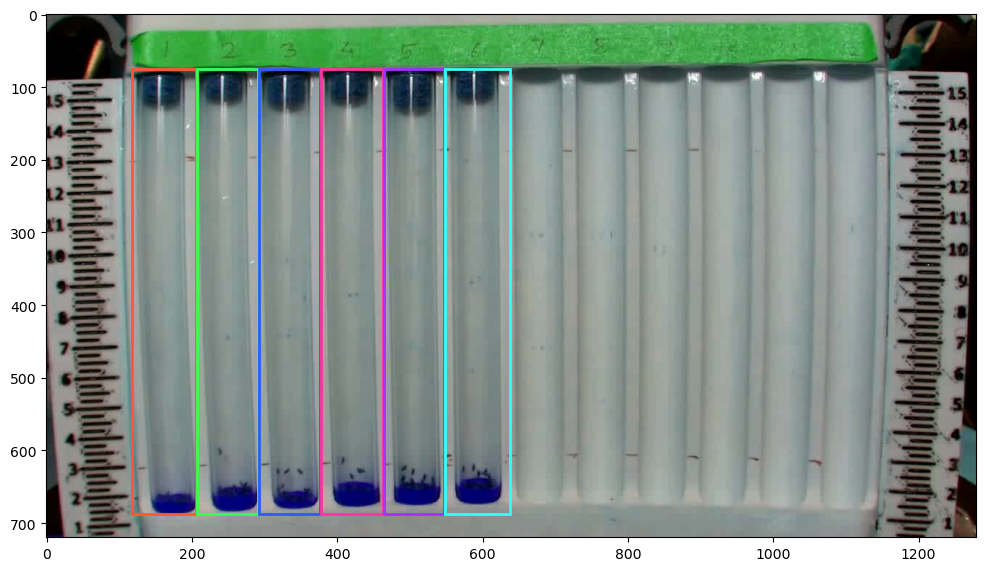

In [8]:
gc.collect()
colors = [
    "#FF5733", "#33FF57", "#3357FF", "#FF33A1", "#A133FF",
    "#33FFF5", "#FF8C33", "#8CFF33", "#5733FF", "#FF3333",
    "#33FFA1", "#A1FF33", "#FFD700", "#40E0D0", "#DC143C",
    "#6495ED", "#008080", "#800080", "#FF4500", "#2E8B57",
    "#00CED1", "#9370DB", "#FA8072", "#7FFF00", "#4682B4",
    "#8B0000", "#20B2AA", "#FF6347", "#DAA520", "#FF00FF"
]



# Archana
# x1=120
# y1=75
# x2=205
# y2=680
# n = 6

# Trim 3
# x1 = 530
# y1 = 90
# x2 = 610
# y2 = 680
# n = 6

# Trim 4
# x1 = 545
# y1 = 90
# x2 = 625
# y2 = 680
# n = 11

# Cut Set 1
# Vial 2
# x1 = 552
# y1 = 72
# x2 = 635
# y2 = 675
# n = 10
# Vial 3
# x1 = 637
# y1 = 80
# x2 = 724
# y2 = 675
# n=10

# Cut Set 3 July 16 Trim 1
# Vial 3
# x1 = 650
# y1 = 75
# x2 = 726
# y2 = 675
# n=10
# Vial 4
# x1 = 735
# y1 = 75
# x2 = 815
# y2 = 675
# n=10

# Cut Set 4 July 19 (New lighting)
x_off = -15

# Vial Number : [x1, x2, y1, y2, num_flies, single_thresh, double_thresh]
    # 4: [478+x_off, 559+x_off, 78, 675, 5, 4],
    # 5: [565+x_off, 648+x_off, 78, 675, 10, 4],
    # 6: [652+x_off, 733+x_off, 78, 675, 15, 4],
    # 7: [738+x_off, 819+x_off, 78, 675, 20, 4]
vials = {
    0: [117, 206, 75, 688, 23, 2, 55],
    1: [207, 291, 75, 688, 23, 2, 55],
    2: [292, 376, 75, 688, 23, 2, 55],
    3: [377, 463, 75, 688, 23, 2, 55],
    4: [464, 547, 75, 688, 23, 2, 55],
    5: [548, 637, 75, 688, 23, 2, 55],
}

plt.figure(figsize=(12, 12))
for v in vials.keys():
    rect = Rectangle((vials[v][0], vials[v][2]), vials[v][1]-vials[v][0], vials[v][3]-vials[v][2], linewidth=2, edgecolor=colors[v], facecolor='none')
    plt.gca().add_patch(rect)

plt.imshow(trim_dict[0]["raw"][0])
plt.show()



In [9]:
for t in range(len(trim_nums)):
    trim_dict[t]["vials"] = {}
    for vial_num in vials.keys():
        trim_dict[t]["vials"][vial_num] = {}

        trim_dict[t]["vials"][vial_num]["x1"] = vials[vial_num][0]
        trim_dict[t]["vials"][vial_num]["x2"] = vials[vial_num][1]
        trim_dict[t]["vials"][vial_num]["y1"] = vials[vial_num][2]
        trim_dict[t]["vials"][vial_num]["y2"] = vials[vial_num][3]

        trim_dict[t]["vials"][vial_num]["n flies"] = vials[vial_num][4]

        trim_dict[t]["vials"][vial_num]["single threshold"] = vials[vial_num][5]
        trim_dict[t]["vials"][vial_num]["double threshold"] = vials[vial_num][6]

Make cropped raw frames for each vial

Trim 1
       Vial 0


100%|██████████| 871/871 [00:00<00:00, 9096.85it/s]


       Vial 1


100%|██████████| 871/871 [00:00<00:00, 9344.40it/s]


       Vial 2


100%|██████████| 871/871 [00:00<00:00, 9157.55it/s]


       Vial 3


100%|██████████| 871/871 [00:00<00:00, 9323.15it/s]


       Vial 4


100%|██████████| 871/871 [00:00<00:00, 9573.63it/s]


       Vial 5


100%|██████████| 871/871 [00:00<00:00, 8721.26it/s]


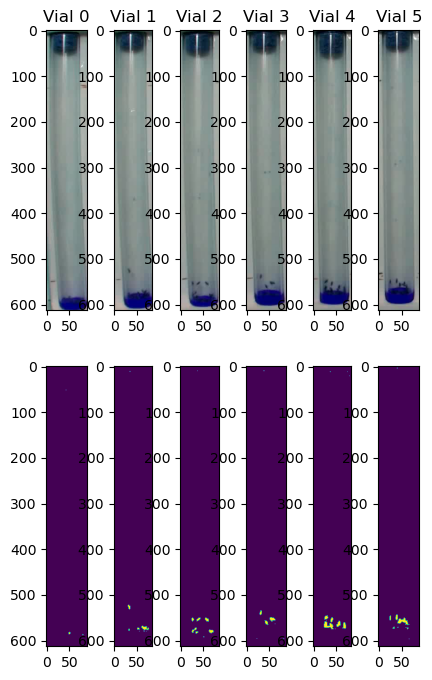

In [10]:
print("Make cropped raw frames for each vial\n")

for t in range(len(trim_nums)):
    print("Trim", trim_nums[t])
    for v in trim_dict[t]["vials"].keys():
        print("       Vial", v)

        trim_dict[t]["vials"][v]["c raw"] = np.zeros(
            (   
                trim_dict[t]["count"],
                trim_dict[t]["vials"][v]["y2"]-trim_dict[t]["vials"][v]["y1"],
                trim_dict[t]["vials"][v]["x2"]-trim_dict[t]["vials"][v]["x1"],
                3
            ),
            dtype=np.uint8
        )
        trim_dict[t]["vials"][v]["c bin"] = np.zeros(
            (   
                trim_dict[t]["count"],
                trim_dict[t]["vials"][v]["y2"]-trim_dict[t]["vials"][v]["y1"],
                trim_dict[t]["vials"][v]["x2"]-trim_dict[t]["vials"][v]["x1"],
            ),
            dtype=np.uint8
        )

        for f in tqdm(range(trim_dict[t]["count"])):
            trim_dict[t]["vials"][v]["c raw"][f] = trim_dict[t]["raw"][f][
                trim_dict[t]["vials"][v]["y1"]:trim_dict[t]["vials"][v]["y2"],
                trim_dict[t]["vials"][v]["x1"]:trim_dict[t]["vials"][v]["x2"]
            ]
            trim_dict[t]["vials"][v]["c bin"][f] = trim_dict[t]["fg bin"][f][
                trim_dict[t]["vials"][v]["y1"]:trim_dict[t]["vials"][v]["y2"],
                trim_dict[t]["vials"][v]["x1"]:trim_dict[t]["vials"][v]["x2"]
            ]
    print()

fig, axes = plt.subplots(2, len(vials), figsize=(5, len(trim_nums)*8))

for i in range(len(vials)):
    axes[0][i].set_title("Vial " + str([j for j in vials.keys()][i]))
    axes[0][i].imshow(trim_dict[0]["vials"][[j for j in vials.keys()][i]]["c raw"][0])
    axes[1][i].imshow(trim_dict[0]["vials"][[j for j in vials.keys()][i]]["c bin"][0])

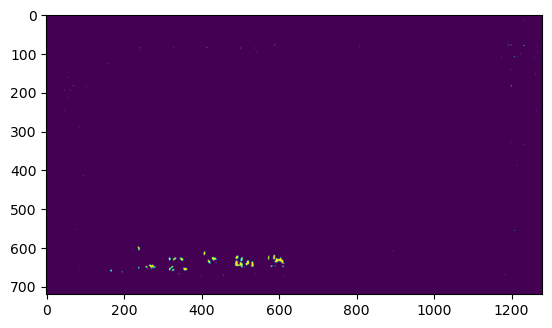

In [11]:
plt.imshow(trim_dict[0]["fg bin"][0])

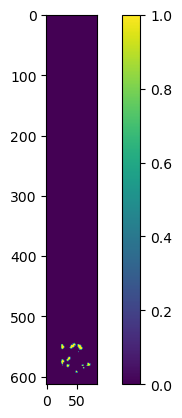

In [12]:
plt.imshow(trim_dict[0]["vials"][2]["c bin"][4])
plt.colorbar()

In [13]:
def connectComp(t, v, f, overlap=False, print_areas=False):
    frame = trim_dict[t]["vials"][v]["c bin"][f]
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(frame, 8, cv2.CV_16U)
    output = np.zeros(frame.shape, dtype="uint8")
    centroid_points = []
    
    final_labels = num_labels
    extra = 0;

    for i in range(1, num_labels): 
        area = stats[i, cv2.CC_STAT_AREA]
        if print_areas: print(area)
        if trim_dict[t]["vials"][v]["single threshold"] < area < trim_dict[t]["vials"][v]["double threshold"]:
            componentMask = (labels == i).astype("uint8") * 255
            output = cv2.bitwise_or(output, componentMask)
            cX, cY = centroids[i]
            centroid_points.append((round(cX, 0), round(cY, 0)))
        elif area > trim_dict[t]["vials"][v]["double threshold"] and overlap:
            componentMask = (labels == i).astype("uint8") * 255
            output = cv2.bitwise_or(output, componentMask)
            cX, cY = centroids[i]
            centroid_points.append((round(cX, 0), round(cY, 0)))
            for j in range(area // trim_dict[t]["vials"][v]["double threshold"]):
                cX, cY = centroids[i]
                cX+=2*(j+1)
                cY+=2*(j+1)
                centroid_points.append((round(cX, 0), round(cY, 0)))
                final_labels+=1;
        else: extra+=1
                
    if overlap: return final_labels-1-extra, output, centroid_points, final_labels-num_labels
    else: return num_labels-1-extra, output, centroid_points

38
36
3
59
Spots: 5 including 1 doubled
(59.0, 569.0)
(58.0, 583.0)
(34.0, 581.0)
(78.0, 585.0)
(80.0, 587.0)


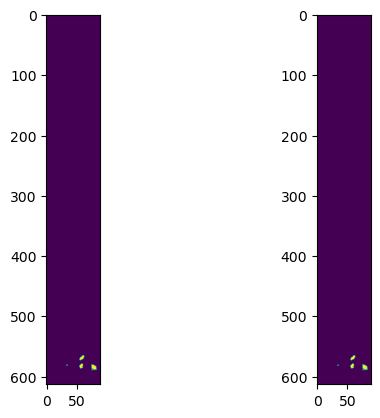

In [14]:
def compareComp(t, v, f):
    num_labels, output, centroids, doubled = connectComp(t, v, f, overlap=True, print_areas=True)

    fig, axes = plt.subplots(1, 2)

    axes[0].imshow(output)
    axes[1].imshow(trim_dict[t]["vials"][v]["c bin"][f])
    print("Spots:", num_labels, "including", doubled, "doubled")
    for c in centroids: print(c)
    
compareComp(0, 0, 10)

In [15]:
print(trim_dict[0]["vials"][1]["single threshold"])
print(trim_dict[0]["vials"][1]["double threshold"])

2
55


In [16]:
print("""
Steps:

1. Find components (flies) in two adjacent frames
* Done through background subtraction

2. Link closeby components from adjacent frames

3. Add to a list of the path of individual flies

# Save images from plot into folders, can use cv2 to stitch together into video

""")


Steps:

1. Find components (flies) in two adjacent frames
* Done through background subtraction

2. Link closeby components from adjacent frames

3. Add to a list of the path of individual flies

# Save images from plot into folders, can use cv2 to stitch together into video




In [17]:
# Change analyze threshold system so it just finds 6 biggest instead above a threshold
# Check if this fixes analyzing, and groups getting linked to same group

In [18]:
print("Analyze all frames of each trim for each vial")

for t in range(len(trim_nums)):
    print("Trim", trim_nums[t])
    for v in vials.keys():
        print("       Vial", v)
        analyzed = []
        for f in tqdm(range(trim_dict[t]["count"])):
            analyzed.append(connectComp(t, v, f, overlap=True))
        trim_dict[t]["vials"][v]["analyzed"] = analyzed
    print()

# flies detected, frame_output, lc, num_doubled

Analyze all frames of each trim for each vial
Trim 1
       Vial 0


100%|██████████| 871/871 [00:00<00:00, 2502.90it/s]


       Vial 1


100%|██████████| 871/871 [00:00<00:00, 2241.16it/s]


       Vial 2


100%|██████████| 871/871 [00:00<00:00, 1646.78it/s]


       Vial 3


100%|██████████| 871/871 [00:00<00:00, 2954.98it/s]


       Vial 4


100%|██████████| 871/871 [00:00<00:00, 1541.04it/s]


       Vial 5


100%|██████████| 871/871 [00:00<00:00, 1671.19it/s]

Frame 15 
 5 Components: 
Group 1 is (63.0, 562.0)
Group 2 is (59.0, 577.0)
Group 3 is (78.0, 582.0)
Group 4 is (80.0, 584.0)
Group 5 is (34.0, 578.0)


[]

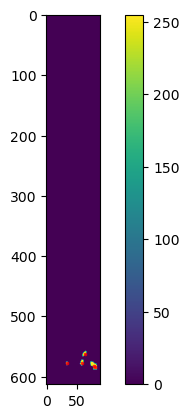

In [19]:
# Testing
f = 15

results = trim_dict[0]["vials"][0]["analyzed"][f]
plt.imshow(results[1])
plt.colorbar()

print("Frame", f, "\n", results[0], "Components: ")
dotx = []
doty = []
for i in range(results[0]):
    print("Group", i+1, "is", results[2][i])
    doty.append(results[2][i][1])
    dotx.append(results[2][i][0]);
plt.scatter(dotx, doty, marker = "x", c="r", s=3, alpha=0.8)
plt.plot()

In [20]:
results

(5,
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 [(63.0, 562.0), (59.0, 577.0), (78.0, 582.0), (80.0, 584.0), (34.0, 578.0)],
 1)

Finding original number of detected flies per frame and number of pixels each takes

Trim 1
       Vial 0


100%|██████████| 871/871 [00:00<00:00, 2732414.95it/s]


       Vial 1


100%|██████████| 871/871 [00:00<00:00, 2840776.66it/s]


       Vial 2


100%|██████████| 871/871 [00:00<00:00, 2759243.79it/s]


       Vial 3


100%|██████████| 871/871 [00:00<00:00, 3014223.42it/s]


       Vial 4


100%|██████████| 871/871 [00:00<00:00, 3024204.29it/s]


       Vial 5


100%|██████████| 871/871 [00:00<00:00, 3001839.59it/s]

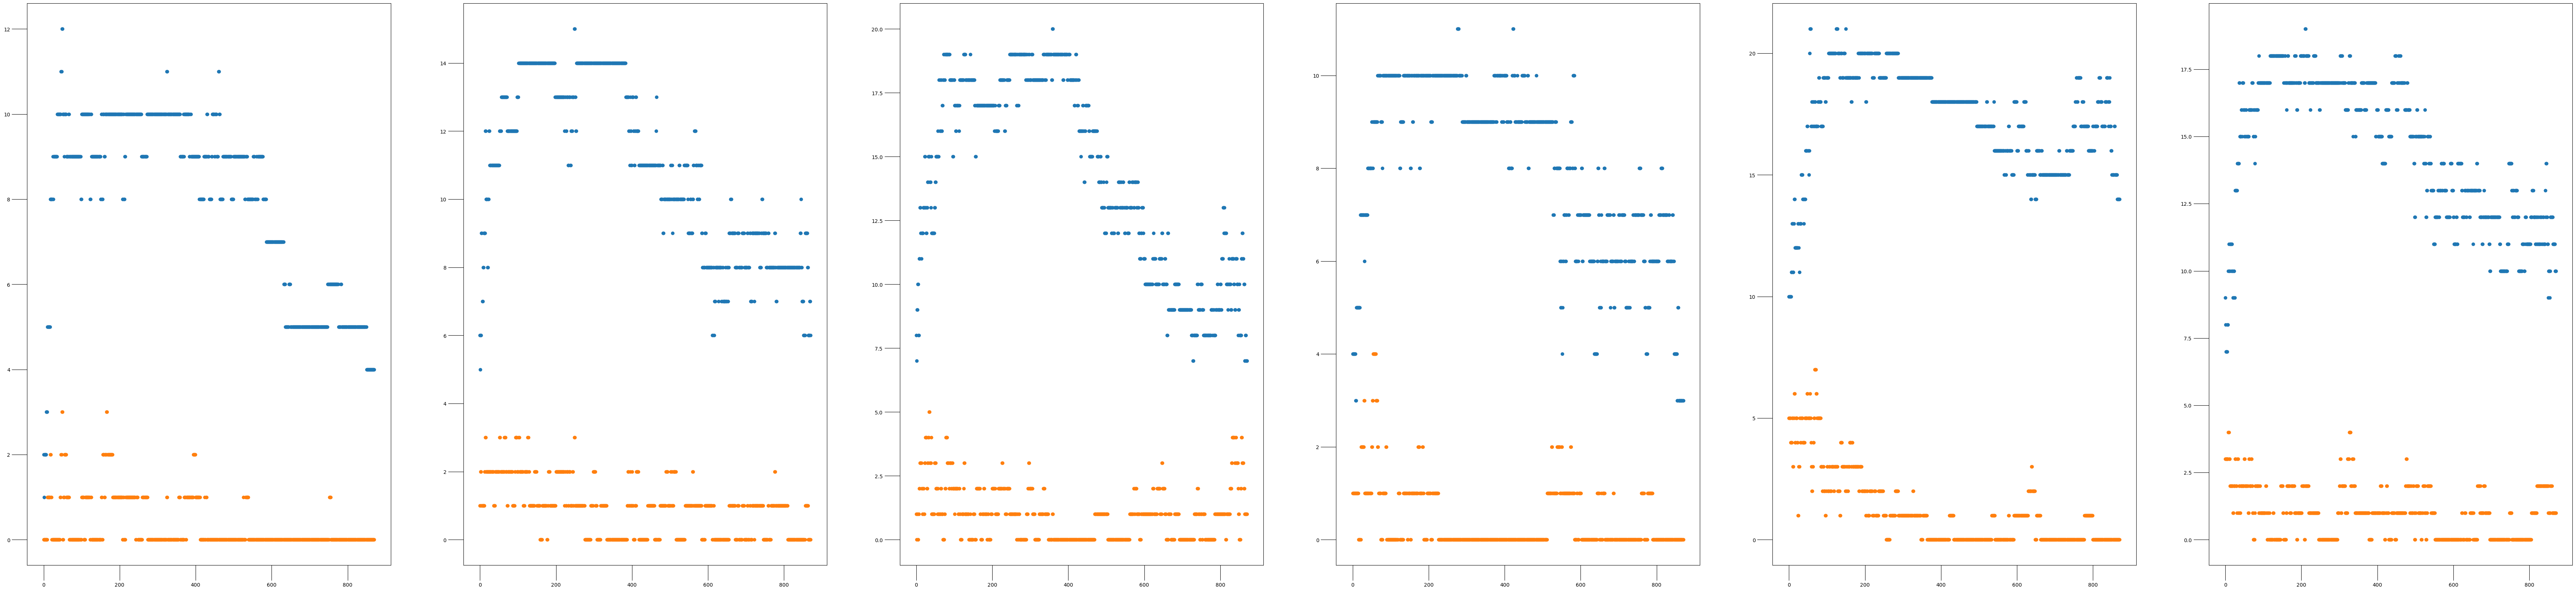

In [21]:
print("Finding original number of detected flies per frame and number of pixels each takes\n")

for t in range(len(trim_nums)):
    print("Trim", trim_nums[t])
    for v in vials.keys():
        print("       Vial", v)
        
        n_groups = []
        for f in tqdm(range(trim_dict[t]["count"])):
            n_groups.append(trim_dict[t]["vials"][v]["analyzed"][f][0])
        trim_dict[t]["vials"][v]["n groups"] = n_groups
        
        try:
            n_doubled = []
            for f in tqdm(range(trim_dict[t]["count"])):
                n_doubled.append(trim_dict[t]["vials"][v]["analyzed"][f][3])
            trim_dict[t]["vials"][v]["n doubled"] = n_doubled
        except:
            print("Double Setting Off")
            
    print()

fig, axes = plt.subplots(len(trim_nums), len(vials), figsize = (len(vials)*15, len(trim_nums*20)))
axes = [axes]

# for i in range(len(vials)): axes[len(trim_nums)][i].set_title("Vial " + str([j for j in vials.keys()][i]))
# for i in range(len(vials)): axes[len(trim_nums)][i].set_title("Vial " + str([j for j in vials.keys()][i]))

for t in range(len(trim_nums)):
    for v in range(len(vials)):
        axes[t][v].scatter([i for i in range(trim_dict[t]["count"])], trim_dict[t]["vials"][[j for j in vials.keys()][v]]["n groups"])
        axes[t][v].scatter([i for i in range(trim_dict[t]["count"])], trim_dict[t]["vials"][[j for j in vials.keys()][v]]["n doubled"])
        axes[t][v].tick_params(axis='both', which='major', size=30)

# plt.savefig(f"./output/{name}_output/og_detected_flies_Trim{trim_nums}_Vial{[i for i in vials.keys()]}.png")

In [22]:
# import numpy as np
# import networkx as nx
# import matplotlib.pyplot as plt
# from scipy.optimize import linear_sum_assignment

# # Simulated detections (frame-wise [x, y] positions)
# # frames = [
# #     np.array([[46, 50], [50, 50], [90, 90]]),  # Frame 0
# #     np.array([[12, 12], [48, 48]]),           # Frame 1 (one missing)
# #     np.array([[14, 14], [46, 46], [90, 90]]), # Frame 2 (fly reappears)
# #     np.array([[16, 16], [44, 44], [88, 88]]), # Frame 3
# # ]

# frames = [np.array(a[2]) for a in trim_dict[0]["vials"][0]["analyzed"]]
# MAX_GAP = 2  # Max frames allowed to reconnect
# MAX_DIST = 60  # Max movement distance per frame
# G = nx.Graph()  # Graph to hold detections

# # Build graph with edges between frames
# for frame_idx in range(len(frames) - 1):
#     for gap in range(1, MAX_GAP + 1):  # Allow skips
#         if frame_idx + gap >= len(frames):
#             continue

#         current_frame = frames[frame_idx]
#         next_frame = frames[frame_idx + gap]

#         for i, pos1 in enumerate(current_frame):
#             for j, pos2 in enumerate(next_frame):
#                 dist = np.linalg.norm(pos1 - pos2)
#                 if dist < MAX_DIST:
#                     G.add_edge((frame_idx, i), (frame_idx + gap, j), weight=dist * gap)

# # Solve optimal matching using Hungarian Algorithm for each frame transition
# assignments = {}
# for frame_idx in range(len(frames) - 1):
#     current_frame = frames[frame_idx]
#     next_frame = frames[frame_idx + 1]

#     cost_matrix = np.full((len(current_frame), len(next_frame)), np.inf)

#     # Fill cost matrix based on edge weights
#     for i in range(len(current_frame)):
#         for j in range(len(next_frame)):
#             if G.has_edge((frame_idx, i), (frame_idx + 1, j)):
#                 cost_matrix[i, j] = np.linalg.norm(current_frame[i] - next_frame[j])

#     # Solve assignment problem
#     row_ind, col_ind = linear_sum_assignment(cost_matrix)

#     # Store matches
#     for i, j in zip(row_ind, col_ind):
#         if cost_matrix[i, j] < np.inf:  # Ensure valid match
#             assignments[(frame_idx, i)] = (frame_idx + 1, j)

# # Visualize the tracking
# plt.figure(figsize=(8, 6))
# colors = ['r', 'g', 'b', 'c', 'm']  # Colors for different flies

# fly_tracks = {}  # Store fly tracks

# # Reconstruct paths
# for (f1, i1), (f2, i2) in assignments.items():
#     if (f1, i1) not in fly_tracks:
#         fly_tracks[(f1, i1)] = [(f1, frames[f1][i1])]
#     fly_tracks[(f1, i1)].append((f2, frames[f2][i2]))

# # Plot results
# plt.figure(figsize=(10, 10))

# for fly_id, track in tqdm(enumerate(fly_tracks.values())):
#     track_points = np.array([p[1] for p in track])
#     plt.plot(track_points[:, 0], track_points[:, 1], marker='o', linestyle='-', color=colors[fly_id % len(colors)])

# # Plot all points for reference
# # for frame_idx, points in tqdm(enumerate(frames)):
#     # plt.scatter(points[:, 0], points[:, 1], color='k', marker='x', label=f'Frame {frame_idx}')

# plt.title("Graph-Based Fly Tracking")
# plt.xlabel("X Position")
# plt.ylabel("Y Position")
# # plt.legend()


In [23]:
# Could have seperate uses for number of flies vs max number of flies in any frame

In [24]:
def get_distance(p1, p2):
    return ((((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2))**(0.5));

In [25]:
def find_mins(present, last, remember_ind, max_dist=50):
    min_distance = []

    for p in range(len(present)): # First index is paired present location, second is old paired location
        min_dist = 9999
        index = -1
        if present[p] == (-1, -1):
            continue;

        for l in last.keys():
            if last[l] == (-1, -1):
                print("I really don't think this should happen in find mins")
    
            distance = get_distance(present[p], last[l])
            # if (l in remember_ind): distance +=10 # no discrimination for now
            
            if distance<min_dist:
                min_dist = distance
                index = l;
        if min_dist<max_dist:
            min_distance.append([min_dist, p, index]) # minimum distance, present, old
        else:
            min_distance.append([9999, p, index])
    return min_distance

"""def smallest_min(min_distance):
    min_dist = 999
    new_index = -1
    old_index = -1

    for i in range in (len(min_distance)):
        if min_distance[i][0]<min_dist:
            min_dist = min_distance[i][0]
            new_index = i
            old_index = min_distance[i][1]
            
    return (min_dist, new_index, old_index);"""

'def smallest_min(min_distance):\n    min_dist = 999\n    new_index = -1\n    old_index = -1\n\n    for i in range in (len(min_distance)):\n        if min_distance[i][0]<min_dist:\n            min_dist = min_distance[i][0]\n            new_index = i\n            old_index = min_distance[i][1]\n            \n    return (min_dist, new_index, old_index);'

In [26]:
import copy

In [27]:
# def graph_tool(

Trim 1
fell 66 fell 100 fell 168 fell 274 fell 324 fell 444 fell 460 
19 flies
fell 24 fell 68 fell 102 fell 104 fell 110 fell 242 fell 248 fell 554 
20 flies
fell 12 fell 16 fell 16 fell 28 fell 30 fell 36 fell 52 fell 60 fell 60 fell 60 fell 84 fell 98 fell 106 fell 106 fell 114 fell 178 fell 220 fell 236 fell 246 fell 290 fell 334 fell 340 fell 348 fell 358 fell 862 
38 flies
fell 32 fell 56 fell 62 fell 62 fell 79 fell 90 fell 134 fell 178 fell 276 fell 483 fell 556 fell 574 fell 690 
21 flies
fell 14 fell 14 fell 22 fell 28 fell 48 fell 54 fell 54 fell 54 fell 55 fell 60 fell 76 fell 78 fell 104 fell 108 fell 136 fell 144 fell 154 fell 520 fell 578 fell 754 
33 flies
fell 12 something went wrong here
fell 18 fell 20 fell 28 fell 34 fell 36 fell 54 fell 70 fell 86 fell 118 fell 164 fell 170 fell 182 fell 198 fell 210 fell 232 fell 324 fell 422 fell 448 fell 504 fell 654 
32 flies

Trim 1


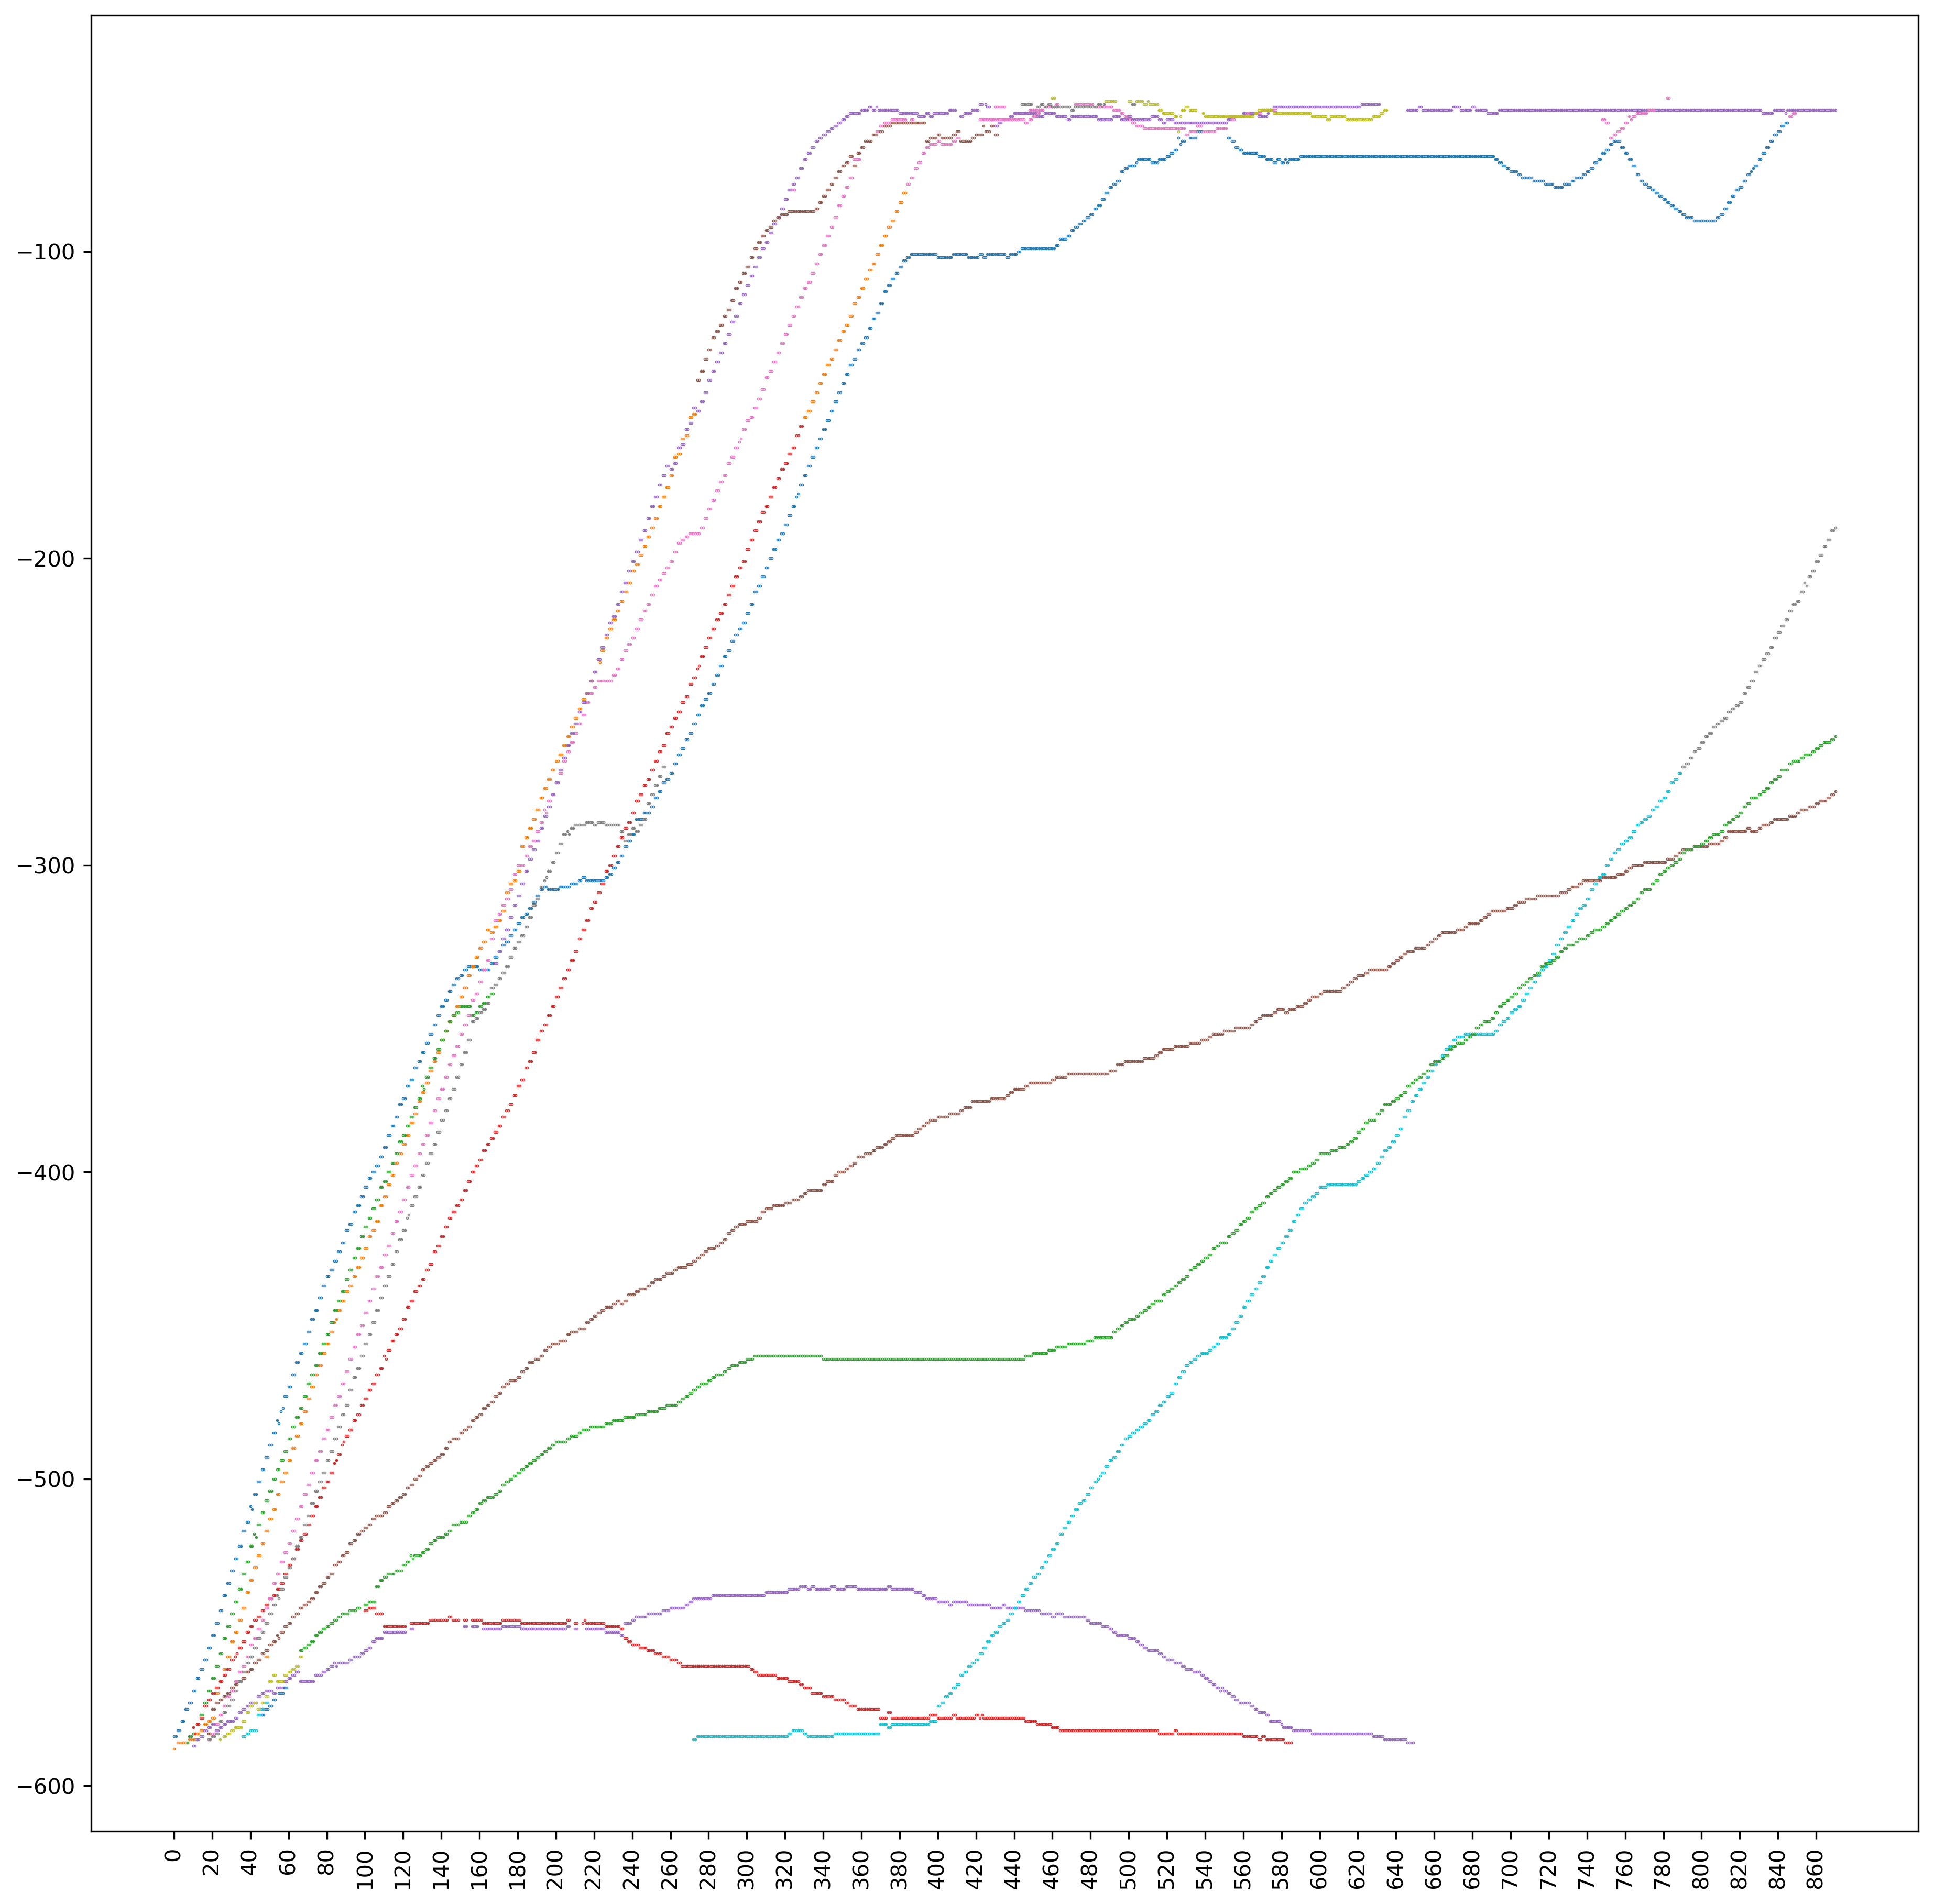

In [28]:
# Pair closest

# when recalculating min dists, can rep dist in vector form so more efficient, look into using graph and nodes if needed

def get_points(t, v):
    clc = [a[2] for a in trim_dict[t]["vials"][v]["analyzed"]][:]
    points = [{}];
    max_dist = 50
    fall_thresh = -10
    max_lookback = 8
    
    for g in range(len(clc[0])): # Put in first frame values
        points[0][g] = clc[0][g];

    residuals = []

    remember = {} # ID: [(x, y), frame_num]
    next_ID = len(clc[0])
    
    def configure_all(frame):
        # Gets necessary remember values into last and deletes remember values that are too old
        
        # Clean out remember
        for key in list(remember.keys()):  # Iterate over a copy of the keys
            if frame - remember[key][1] > max_lookback:
                del remember[key]
        
        present = clc[frame][:]
        last = copy.deepcopy(points[frame-1])
        remember_ind = [] # Adding remember into last and figuring out ind to take out
        
        for re in remember.keys():
            remember_ind.append(re)
            if re in last: print("something went wrong here")
            last[re] = remember[re][0]
            
        new_need = [i for i in range(len(present))] # New groups that need to be paired
        old_need = [i for i in last.keys()] # Old groups that need to be paired
        
        return present, last, remember_ind, new_need, old_need

    for frame in range(1, len(clc)): # for each frame
        present, last, remember_ind, new_need, old_need = configure_all(frame)
        positions = {}
        frame_residuals = {}

        min_distance = sorted(find_mins(present, last, remember_ind, max_dist=max_dist)) # For each group: [min_dist, paired new index, closest old index]
        
        o=0
        while(len(old_need)>0):
            
            if len(new_need)>0:
                
                if (min_distance[o][2] not in old_need or min_distance[o][1] not in new_need):
                    
                    del min_distance[o:]
                    
                    f_present = [(-1, -1) for i in present]
                    f_last = {}
                    
                    for ne in new_need:
                        f_present[ne] = present[ne]
                    for ol in old_need:
                        f_last[ol] = last[ol]
                        
                    for item in sorted(find_mins(f_present, f_last, remember_ind)):
                        min_distance.append(item)
                
                if present[min_distance[o][1]][1]-last[min_distance[o][2]][1] > fall_thresh and min_distance[o][0]!=9999:
                    positions[min_distance[o][2]] = present[min_distance[o][1]]
                    frame_residuals[min_distance[o][2]] = round(min_distance[o][0], 2)

                    if min_distance[o][2] in remember_ind:
                        del remember[min_distance[o][2]]
                    old_need.remove(min_distance[o][2])
                    new_need.remove(min_distance[o][1])
                else:
                    print("fell", frame, end=" ")
                    positions[next_ID] = present[min_distance[o][1]]
                    remember[min_distance[o][2]] = [last[min_distance[o][2]], frame]
                    new_need.remove(min_distance[o][1])
                    next_ID+=1
                o+=1
              
            else: # if more flies in last frame than in current frame 
                for ol in old_need:
                    remember[ol] = [last[ol], frame]
                break;

        for ne in new_need:
            positions[next_ID] = present[ne]
            next_ID+=1

        points.append(positions)
        residuals.append(frame_residuals)

    trim_dict[t]["vials"][v]["graphs"] = next_ID
    trim_dict[t]["vials"][v]["points"] = points
    trim_dict[t]["vials"][v]["residuals"] = residuals;
    print()
    print(next_ID, "flies")
    return points

for t in range(len(trim_nums)):
    print("Trim", trim_nums[t])
    # for v in tqdm(vials.keys()):
    for v in vials.keys():
        get_points(t, v)
    print()

for t in range(len(trim_nums)):
    fig, axes = plt.subplots(1, 1, figsize=(15, 15), dpi = 300)
    axes.set_xticks(np.arange(0, trim_dict[t]["count"], 20))
    axes.tick_params(axis = 'x', labelrotation = 90)
    print("Trim", trim_nums[t])
    
    for v in [0]:# tqdm(vials.keys()):
        for g in range(trim_dict[t]["vials"][v]["graphs"]):
            in_points = []
            in_frames = []
            
            for frame in range(len(trim_dict[t]["vials"][v]["points"])):
                if g in trim_dict[t]["vials"][v]["points"][frame]:
                    in_frames.append(frame)
                    in_points.append(-trim_dict[t]["vials"][v]["points"][frame][g][1])
                    
            axes.scatter(in_frames, in_points, s=.5, marker=".")

Trim 1 Residuals


  0%|          | 0/6 [00:00<?, ?it/s]


AttributeError: 'numpy.float64' object has no attribute 'values'

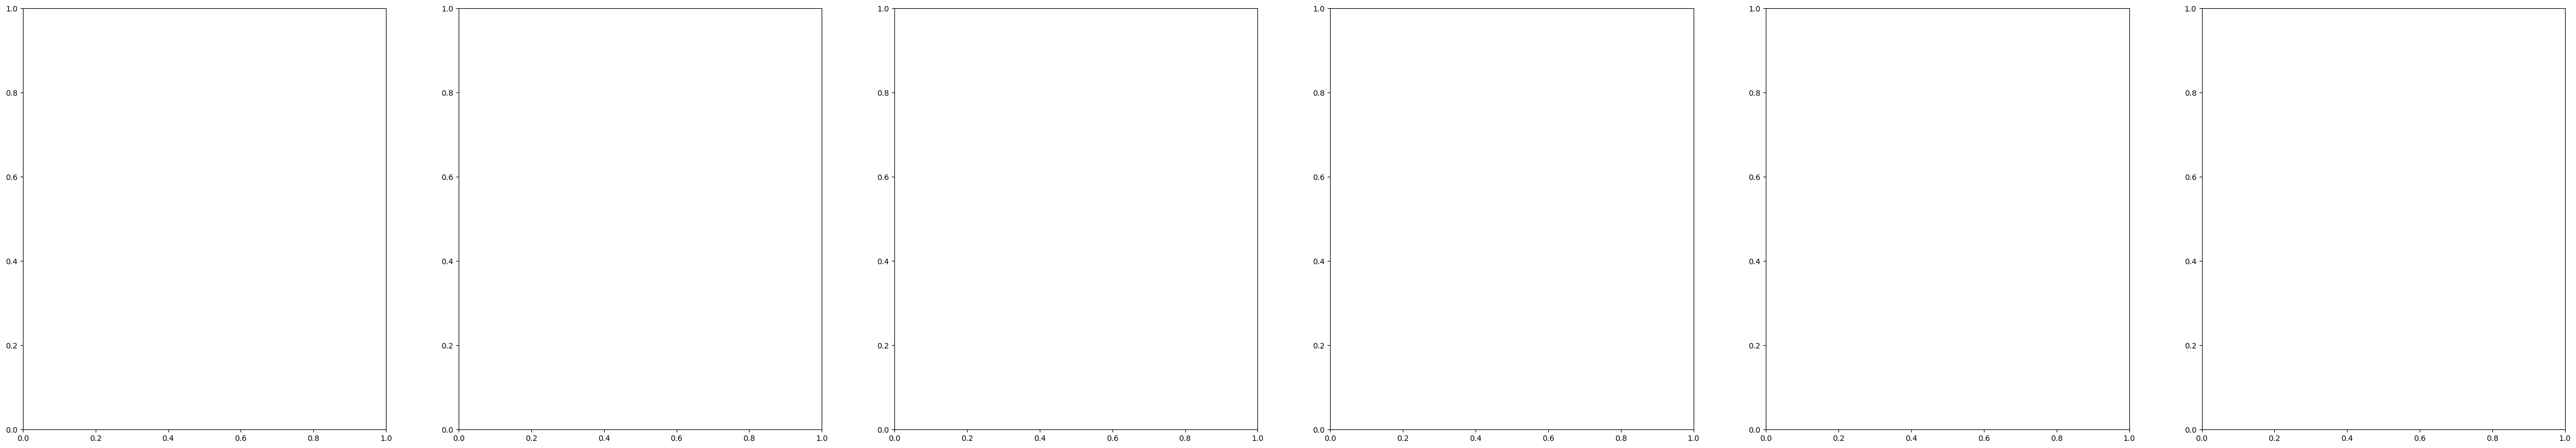

In [155]:
fig, axes = plt.subplots(len(trim_nums), len(vials), figsize=(len(vials)*10, len(trim_nums)*10))
if (len(trim_nums))==1 : axes = [axes]

for t in range(len(trim_nums)):
    print("Trim", trim_nums[t], "Residuals")
    v_num = 0
    for v in tqdm(vials.keys()):
        x = []
        y = []
        c_s = []
        for r in range(len(trim_dict[t]["vials"][v]["residuals"])):
            for c in range(len(trim_dict[t]["vials"][v]["residuals"][r].values())):
                x.append(r)
                y.append((list(trim_dict[t]["vials"][v]["residuals"][r][c].values())))
                c_s.append(c)
        axes[t][v_num].scatter(x, y, c = c_s, s=10)
        axes[t][v_num].set_xticks(np.arange(0, trim_dict[t]["count"], 20))
        axes[t][v_num].tick_params(axis='x', labelrotation=90)
        v_num+=1
    print()

plt.savefig(f"./output/{name}_output/Residuals_Trim{trim_nums}_Vial{[i for i in vials.keys()]}.png")

In [37]:
for t in range(len(trim_nums)):
    print("Trim", trim_nums[t])

    for v in tqdm(vials.keys()):
        points = trim_dict[t]["vials"][v]["points"]
        filtered_points = []
        last = [[-1, -1] for i in range(trim_dict[t]["vials"][v]["n flies"])]

        for f in range(trim_dict[t]["count"]):
            filtered_points.append([[-1, -1] for i in range(trim_dict[t]["vials"][v]["n flies"])])
            for g in range(trim_dict[t]["vials"][v]["n flies"]):
                if points[f][g][0]>520 or points[f][g][0]<100:
                    continue
                if points[f][g]==[-1, -1]:
                    continue
                elif last[g] == [-1, -1]:
                    last[g] = points[f][g]
                    filtered_points[f][g] = points[f][g]
                elif last[g][0]-points[f][g][0]>=-10:
                    last[g] = points[f][g]
                    filtered_points[f][g] = points[f][g]
        
        trim_dict[t]["vials"][v]["filtered points"] = filtered_points


Trim 1


100%|██████████| 6/6 [00:00<00:00, 44.09it/s]


In [26]:
"""

    [   
                                distance
            old     g1    g2    g3    g4    g5    g6           col count = len(last)
        new
        #1        [  a,    b,    c,    d,    e,    f  ]
        #2        []
        #3        []
        #4        []
        #5        []
        #6        []

row count = len(present)

    ]

"""
"""

min_distance:
    [
        #1    [shortest dist to old, closest old group #]
        #2    []
        #3    []
        #4    []
        #6    []
        #5    []
    ]

    
6 --> 5
Pair 5, remember 6th

5 --> 6 after remember
Pair 5, pair 6th with remembered

5 --> 6 w/o remember
Pair 5, start 6th

- Take out jumps in a filtered version of the pots (only want to measure speed of movement of flies)
- Make sure 10 flies analysis works, get cleaner videos from Dave
- Make sure current analysis algorithm is not the problem for the 10 flies
"""

'\n\nmin_distance:\n    [\n        #1    [shortest dist to old, closest old group #]\n        #2    []\n        #3    []\n        #4    []\n        #6    []\n        #5    []\n    ]\n\n    \n6 --> 5\nPair 5, remember 6th\n\n5 --> 6 after remember\nPair 5, pair 6th with remembered\n\n5 --> 6 w/o remember\nPair 5, start 6th\n\n- Take out jumps in a filtered version of the pots (only want to measure speed of movement of flies)\n- Make sure 10 flies analysis works, get cleaner videos from Dave\n- Make sure current analysis algorithm is not the problem for the 10 flies\n'

## Check

In [27]:
data = []
meta_data = []
for t in range(len(trim_nums)):
    print("Trim", trim_nums[t])
    data.append([])
    meta_data.append([])
    vial_num = 0
    for v in tqdm(vials.keys()):
        md = {}
        md["Set"] = set
        md["Trim"] = trim_nums[t]
        md["Vial"] = v
        md["Frame Count"] = trim_dict[t]["count"]
        md["x1"] = trim_dict[t]["vials"][v]["x1"]
        md["x2"] = trim_dict[t]["vials"][v]["x2"]
        md["y1"] = trim_dict[t]["vials"][v]["y1"]
        md["y2"] = trim_dict[t]["vials"][v]["y2"]
        md["Fly Count"] = trim_dict[t]["vials"][v]["n flies"]
        md["Single Threshold"] = trim_dict[t]["vials"][v]["single threshold"]
        md["Double Threshold"] = trim_dict[t]["vials"][v]["double threshold"]
        meta_data[t].append(pd.DataFrame(md, index=["Value"]))

        d = {}
        for g in range(trim_dict[t]["vials"][v]["n flies"]):
            d[f"Unfiltered {g+1}"] = [pt[g] for pt in trim_dict[t]["vials"][v]["points"]]
        for g in range(trim_dict[t]["vials"][v]["n flies"]):
            d[f"Filtered {g+1}"] = [pt[g] for pt in trim_dict[t]["vials"][v]["filtered points"]]
        data[t].append(pd.DataFrame(d))

        meta_data[t][vial_num].to_csv(f'./output/{name}_output/Set{set}_Trim{trim_nums[t]}_Vial{v}_MetaData.csv')
        data[t][vial_num].to_csv(f'./output/{name}_output/Set{set}_Trim{trim_nums[t]}_Vial{v}_Data.csv')
        vial_num+=1


Trim 3


100%|██████████| 2/2 [00:00<00:00, 44.03it/s]


Trim 4


100%|██████████| 2/2 [00:00<00:00, 83.84it/s]


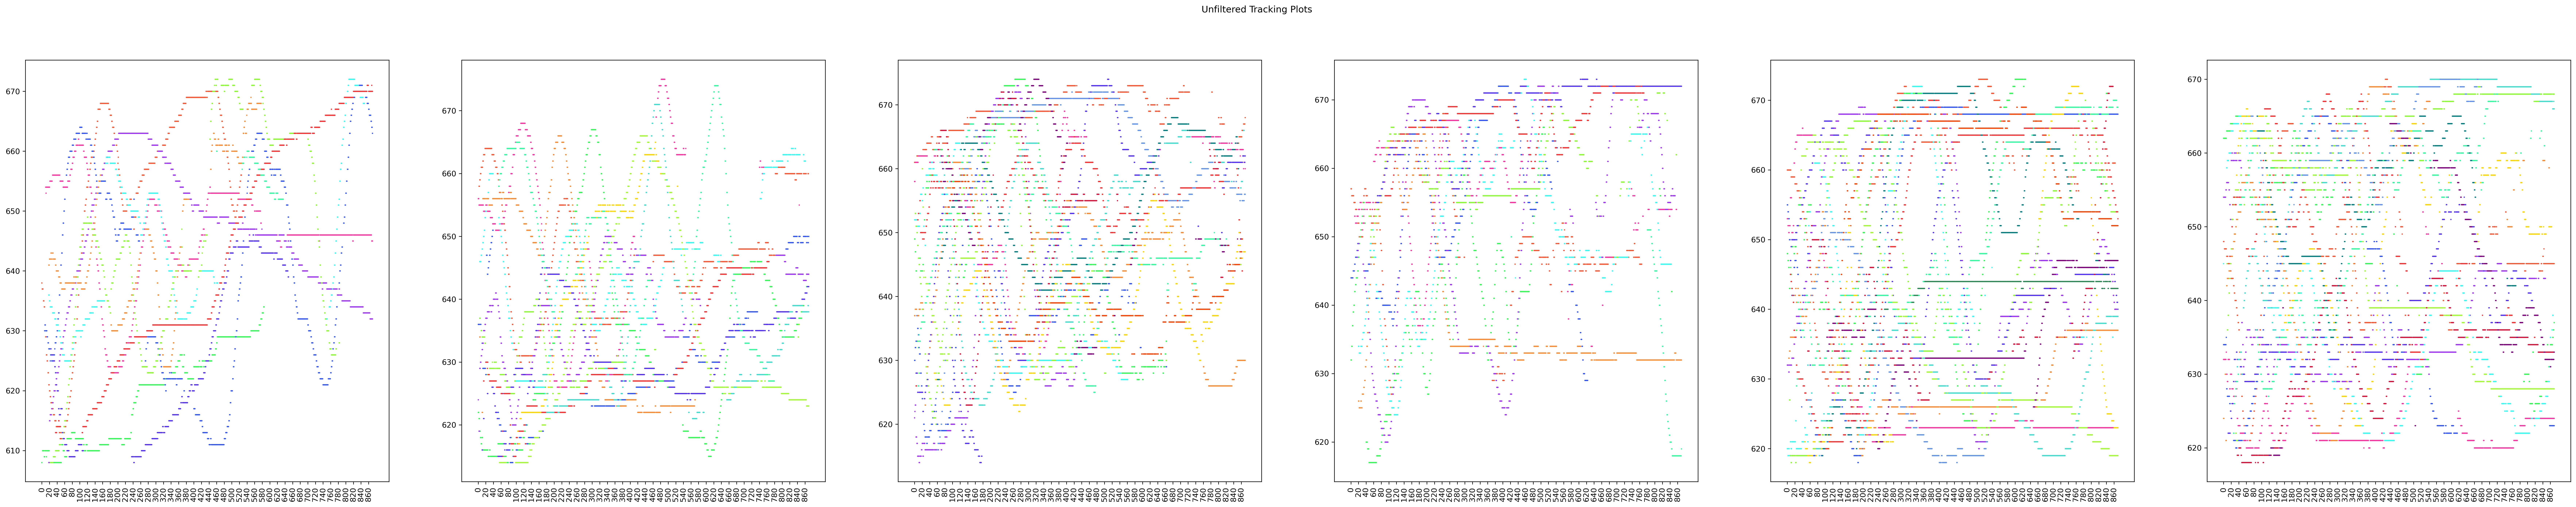

In [43]:
# Use binned avg?

fig, axes = plt.subplots(len(trim_nums), len(vials), figsize=(len(vials)*10, len(trim_nums)*10), dpi = 300)
if (len(trim_nums))==1: axes = [axes]
plt.suptitle("Unfiltered Tracking Plots")

for t in range(len(trim_nums)):
    v_num = 0
    for v in vials.keys():
        groups = [i for i in range(vials[v][4])]
        frames_in = [[] for i in range(vials[v][4])]
        axes[t][v_num].set_xticks(np.arange(0, trim_dict[t]["count"], 20))
        axes[t][v_num].tick_params(axis = 'x', labelrotation = 90)
        for g in groups:
            for f in range(trim_dict[t]["count"]):
                if (trim_dict[t]["vials"][v]["points"][f][g]) != [-1, -1]:
                    frames_in[g].append(f)
            axes[t][v_num].scatter(
                [f_in for f_in in frames_in[g]],
                [trim_dict[t]["vials"][v]["y2"]-trim_dict[t]["vials"][v]["points"][y][g][0] for y in frames_in[g]],
                marker = ".",
                s = 2,
                c=colors[g],
            )
        v_num+=1

plt.savefig(f"./output/{name}_output/Unfiltered_Plot_Trim{trim_nums}_Vial{[i for i in vials.keys()]}.png")

IndexError: list index out of range

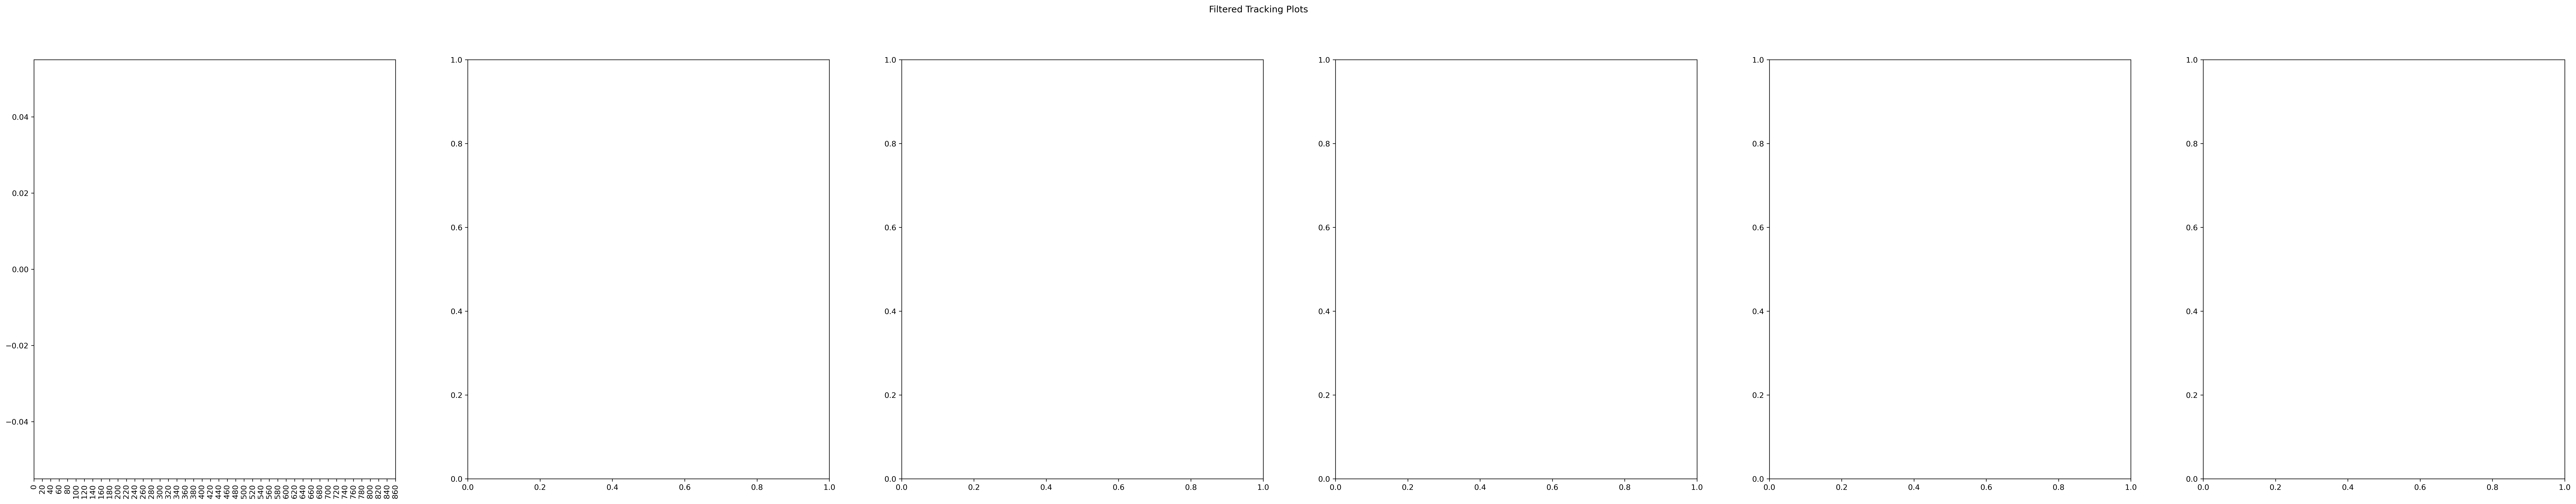

In [41]:
fig, axes = plt.subplots(len(trim_nums), len(vials), figsize=(len(vials)*10, len(trim_nums*10)), dpi = 300)
if (len(trim_nums))==1: axes = [axes]
plt.suptitle("Filtered Tracking Plots")

for t in range(len(trim_nums)):
    v_num = 0
    for v in vials.keys():
        groups = [i for i in range(vials[v][4])]
        frames_in = [[] for i in range(vials[v][4])]
        axes[t][v_num].set_xticks(np.arange(0, trim_dict[t]["count"], 20))
        axes[t][v_num].tick_params(axis = 'x', labelrotation = 90)
        for g in groups:
            for f in range(trim_dict[t]["count"]):
                if (trim_dict[t]["vials"][v]["filtered points"][f][g]) != [-1, -1]:
                    frames_in[g].append(f)
            axes[t][v_num].scatter(
                [f_in for f_in in frames_in[g]],
                [trim_dict[t]["vials"][v]["y2"]-trim_dict[t]["vials"][v]["filtered points"][y][g][0] for y in frames_in[g]],
                marker = ".",
                s = 2,
                c=colors[g],
            )
        v_num+=1

plt.savefig(f"./output/{name}_output/Filtered_Plot_Trim{trim_nums}_Vial{[i for i in vials.keys()]}.png")

In [30]:
# f = 23
# plus = 1



# plt.figure(figsize=(12,8), dpi = 150)

# # rect = Rectangle((0, 0), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
# # plt.gca().add_patch(rect)

# plt.imshow(get_sum(fg_bin_cropped[f],fg_bin_cropped[f+plus])[0], cmap = plt.get_cmap("Grays"))
# # plt.scatter([10 for i in range(n)], [t[f][0] for t in points], marker = ".", c="r", s=10, alpha=0.8)
# # plt.scatter([20 for i in range(n)], [t[f+plus][0] for t in points], marker = ".", c="w", s=10, alpha=0.8)

# for t in range(n):
#     if points[f][t]!=[-1, -1]:
#         plt.plot(points[f][t][1]-x1, points[f][t][0]-y1, marker = "+", color = colors[t])
# for t in range(n):
#     if points[f][t]!=[-1, -1]:
#         plt.plot(points[f+plus][t][1]-x1, points[f+plus][t][0]-y1, marker = "+", color = colors[t])

# #plt.plot(points[0][f], points[0][f+plus], color="w", alpha=0.5)

# for t in range(n):
#     if (points[f][t]!=[-1, -1] and points[f+plus][t]!=[-1, -1]):
#         plt.plot([points[f][t][1]-x1, points[f+plus][t][1]-x1], [points[f][t][0]-y1, points[f+plus][t][0]-y1], color = colors[t])
#         print("Pair", points[f][t], points[f+plus][t]);

# plt.show()

In [31]:
def get_path(t, v):
    path_tracing = []
    graph = [i for i in range(trim_dict[t]["vials"][v]["n flies"])]
    plt.figure(figsize=(8, 15), dpi=150)
    plt.imshow(trim_dict[t]["vials"][v]["c raw"][0])

    for g in tqdm(graph):
        path_tracing.append([])

        prev = []
        prev_ind = -1
        for f in range(trim_dict[t]["count"]):
            pnt = trim_dict[t]["vials"][v]["points"][f][g]

            if pnt!=[-1, -1]:
                prev = pnt
                prev_ind = f
                break;

        for f in range(prev_ind+1, trim_dict[t]["count"]):
            pnt = trim_dict[t]["vials"][v]["points"][f][g]

            if pnt!=[-1,-1]:
                if prev!=[-1,-1]:
                    plt.plot([prev[1], pnt[1]], [prev[0], pnt[0]], color = colors[g], marker=".", markersize=1)
                    prev = pnt
                else:
                    plt.plot(pnt[1], pnt[0], color = colors[g], marker=".", markersize = 1)
                    prev = pnt
            else:
                prev = [-1,-1]
    plt.show()
get_path(0, 7)

KeyError: 7

In [31]:
!ffmpeg -version

/bin/bash: ffmpeg: command not found


  0%|          | 1/871 [01:08<16:32:39, 68.46s/it]


Trim 1
       Vial 0


  0%|          | 0/871 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: 'ffmpeg'

  0%|          | 1/871 [00:00<06:33,  2.21it/s]

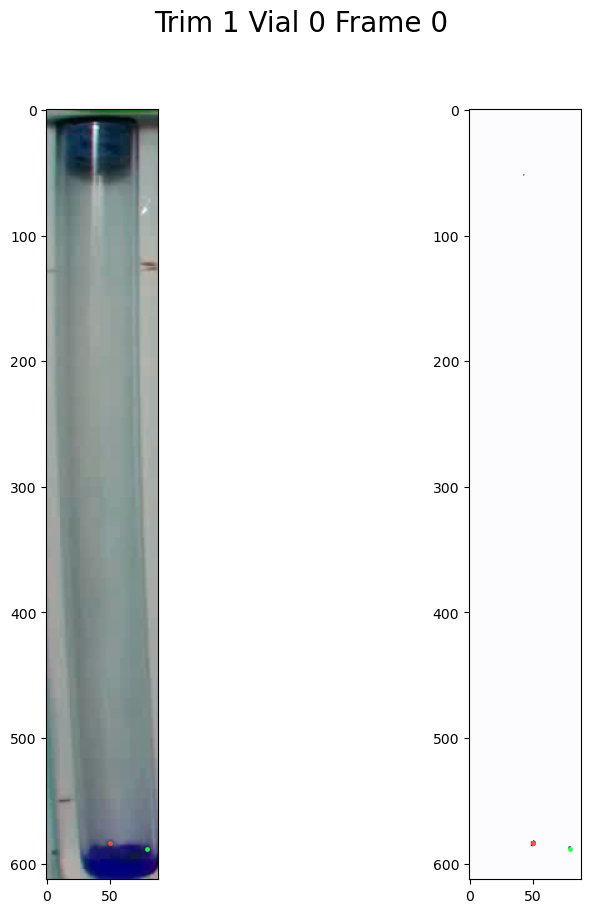

In [32]:
progress_bar = None
title = None

def update_frame(f, t, v, ax1, ax2):
    global progress_bar
    global title
    ax1.clear()
    ax2.clear()

    ax1.imshow(trim_dict[t]["vials"][v]["c raw"][f])
    ax2.imshow(trim_dict[t]["vials"][v]["c bin"][f], cmap = plt.get_cmap("Purples"))
    title.set_text(f"Trim {trim_nums[t]} Vial {v} Frame {f}")

    frame_points = trim_dict[t]["vials"][v]["points"][f]
    for key, value in frame_points.items():
        ax1.plot(value[0], value[1], marker = ".", color=colors[key%30], alpha=0.8, markersize=5)
        ax2.plot(value[0], value[1], marker = ".", color=colors[key%30], alpha=1, markersize=5)
    
    progress_bar.update(1)

def make_video(t, v):
    global progress_bar 
    global title
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    title = plt.suptitle(t='', fontsize = 20)

    total_frames = len(trim_dict[t]["vials"][v]["points"])

    progress_bar = tqdm(total=total_frames)

    vid = animation.FuncAnimation(
        fig, 
        update_frame,
        frames = total_frames,
        fargs=(t, v, ax1, ax2),
        repeat=False
    )

    return vid;

writer = FFMpegWriter(fps=2, codec='libx264')

for t in range(len(trim_nums)):
    print("Trim", trim_nums[t])
    for v in vials.keys():
        print("       Vial", v)
        video = make_video(t, v)
        video.save(f"./output/{name}_output/Set{set}_Trim{trim_nums[t]}_Vial{v}_Tracking.mp4", writer=writer)
        progress_bar.close()

In [32]:
def to_list(str):
    lis = str.strip("][").split(", ")
    ret = [eval(i) for i in lis]
    return ret;

colors = [
    "#ff1100", "#561873", "#f7d872", "#5c2926","#878386",
    "#f7c10c", "#ff6e63", "#89e81c", "#678f39","#2d36ad",
    "#2d6946", "#12db66", "#2fb8d4", "#557f87", "#2d4018",
    "#234e57", "#6066b5", "#9a60b5", "#d1288d", "#533278"
]

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from matplotlib.patches import Rectangle
import cv2
import ipywidgets as widgets
import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter

In [ ]:
# csv to unfiltered plot

trim_display = [1, 2]
vial_display = [0, 1, 2, 3, 4]
set=2
name = f"Dev_SetRun{set}_W1118_CLK_out_2.5wk_Jan_31_2025"

fig, axes = plt.subplots(len(trim_display), len(vial_display), figsize=(len(vial_display)*10, len(trim_display*10)), dpi = 150)
if (len(trim_display))==1: axes = [axes]
if (len(vial_display)) == 1:
    for i in range(trim_display):
        axes[i] = [axes[i]]
plt.suptitle(f"{name} Unfiltered Tracking Plots for Trim {trim_display} Vial {vial_display}")

for t in range(len(trim_display)):
    v_num = 0
    for v in vial_display:
        d = pd.read_csv(f"./output/{name}_output/Set{set}_Trim{trim_display[t]}_Vial{v}_Data.csv")
        md = pd.read_csv(f"./output/{name}_output/Set{set}_Trim{trim_display[t]}_Vial{v}_MetaData.csv")

        groups = [i for i in range(md.get("Fly Count")[0])]
        frames_in = [[] for i in range(md.get("Fly Count")[0])]

        axes[t][v_num].set_xticks(np.arange(0, md.get("Frame Count")[0], 20))
        axes[t][v_num].tick_params(axis = 'x', labelrotation = 90)

        for g in groups:
            column = d.get(f"Unfiltered {g+1}")
            column = [to_list(i) for i in column]

            for f in range(md.get("Frame Count")[0]):
                if column[f] != [-1, -1]:
                    frames_in[g].append(f)
            axes[t][v_num].scatter(
                [f_in for f_in in frames_in[g]],
                [md.get("y2")[0]-column[f][0] for f in frames_in[g]],
                marker = ".",
                s = 2,
                c=colors[g],
            )
        v_num+=1

for x in range(len(axes[0])):
    axes[0][x].set_title(f"Vial {vial_display[x]}")
for x in range(len(axes)):
    axes[x][0].set_ylabel(f"Trim {trim_display[x]}", rotation=0, size='large')

plt.savefig(f"./output/{name}_output/UnfilteredPlot_Trim{trim_display}_Vial{vial_display}.png")

[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, -1, 0, 3, 3, 3, 3, 5, 5, -1, 5, -1, -1, -1, 5, 7, 7, 9, 9, 13, 13, 14, -1, 14, 14, 20, 20, 24, 24, 25, 25, -1, 25, 30, 30, 32, 32, 39, 39, -1, 39, 44, 44, 48, 48, 48, 48, 53, 53, 55, 55, 58, 58, 58, 58, 59, 59, -1, 59, 64, -1, 68, 68, 69, 69, -1, 69, 74, 74, 77, 78, -1, 78, 89, 89, -1, 89, 89, 89, 91, 91, -1, 91, 98, 98, -1, 98, 100, -1, 102, 102, 104, 104, -1, 104, 106, 106, 117, 117, -1, 117, 127, -1, 127, 127, 128, 128, 134, 134, 135, 135, 137, 137, -1, 137, 137, 138, 139, 139, 142, 142, 142, 142, -1, 142, -1, 142, 144, 144, -1, 144, 148, 148, 149, 149, -1, 149, 155, -1, -1, 155, 157, 157, 157, 157, 157, -1, 158, 158, 161, -1, 163, 163, -

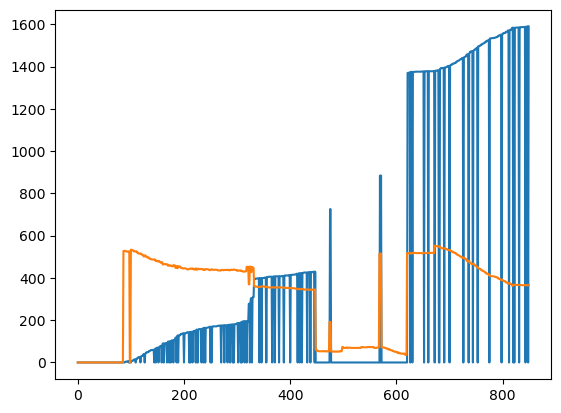

In [38]:
# Extra filtering

trim_display = [3, 4]
vial_display = [4]

y_bound = [150, 600]
thresh = 0
fell_down_thresh = -10

for t in range(len(trim_display)):
    vial_num = 1
    for v in vial_display:
        d = pd.read_csv(f"./output/{name}_output/Set{set}_Trim{trim_display[t]}_Vial{v}_Data.csv")
        md = pd.read_csv(f"./output/{name}_output/Set{set}_Trim{trim_display[t]}_Vial{v}_MetaData.csv")

        groups = [i for i in range(md.get("Fly Count")[0])]
        fp = [[] for i in range(len(groups))]
        went_down = [False for i in range(len(groups))]

        for g in groups:
            last = []
            first = []
            last_valid = []
            poi = d[f"Unfiltered {g+1}"]
            cnt = 0
            for p in poi:
                cnt+=1
                p = to_list(p)
                if p == [-1, -1]:
                    fp[g].append([-1, -1])
                elif last == []:
                    last = p
                    first = p
                    last_valid = p
                    if (p[0]>y_bound[0] and p[0]<y_bound[1]):
                        fp[g].append([0, p[1]])
                    else: fp[g].append([-1, -1])
                else:
                    ydiff = last[0]-p[0]
                    if (ydiff>=thresh):
                        if (p[0]>y_bound[0] and p[0]<y_bound[1]):
                            fp[g].append([(first[0]-last_valid[0])+ydiff, p[1]])
                        else: fp[g].append([-1, -1])
                        last_valid = [last_valid[0]-ydiff, p[1]]
                    else:
                        fp[g].append([-1, -1])
                    last = p
                    if (ydiff<fell_down_thresh):
                        went_down[g] = True
                
        de = {}
        for g in range(len(groups)):
            de[f"Unfiltered {g+1}"] = d[f"Unfiltered {g+1}"]
        for g in range(len(groups)):
            de[f"Filtered {g+1}"] = fp[g]
        pd.DataFrame(de).to_csv(f'./output/{name}_output/Set{set}_Trim{trim_display[t]}_Vial{v}_NewData.csv')
        vial_num+=1
        wd = {}
        for g in range(len(groups)):
            wd[f"Fly {g}"] = went_down[g]
        pd.DataFrame(list(wd.items()), columns=["Fly", "WentDown"]).to_csv(f'./output/{name}_output/Set{set}_Trim{trim_display[t]}_Vial{v}_WentDown.csv')

plt.plot([i for i in range(len(poi))], [j[0] for j in fp[g]])

# Plot the second set of y-values
plt.plot([i for i in range(len(poi))], [to_list(p)[0] for p in poi])
print([j[0] for j in fp[g]])
print([to_list(p)[0] for p in poi])


TypeError: 'list' object cannot be interpreted as an integer

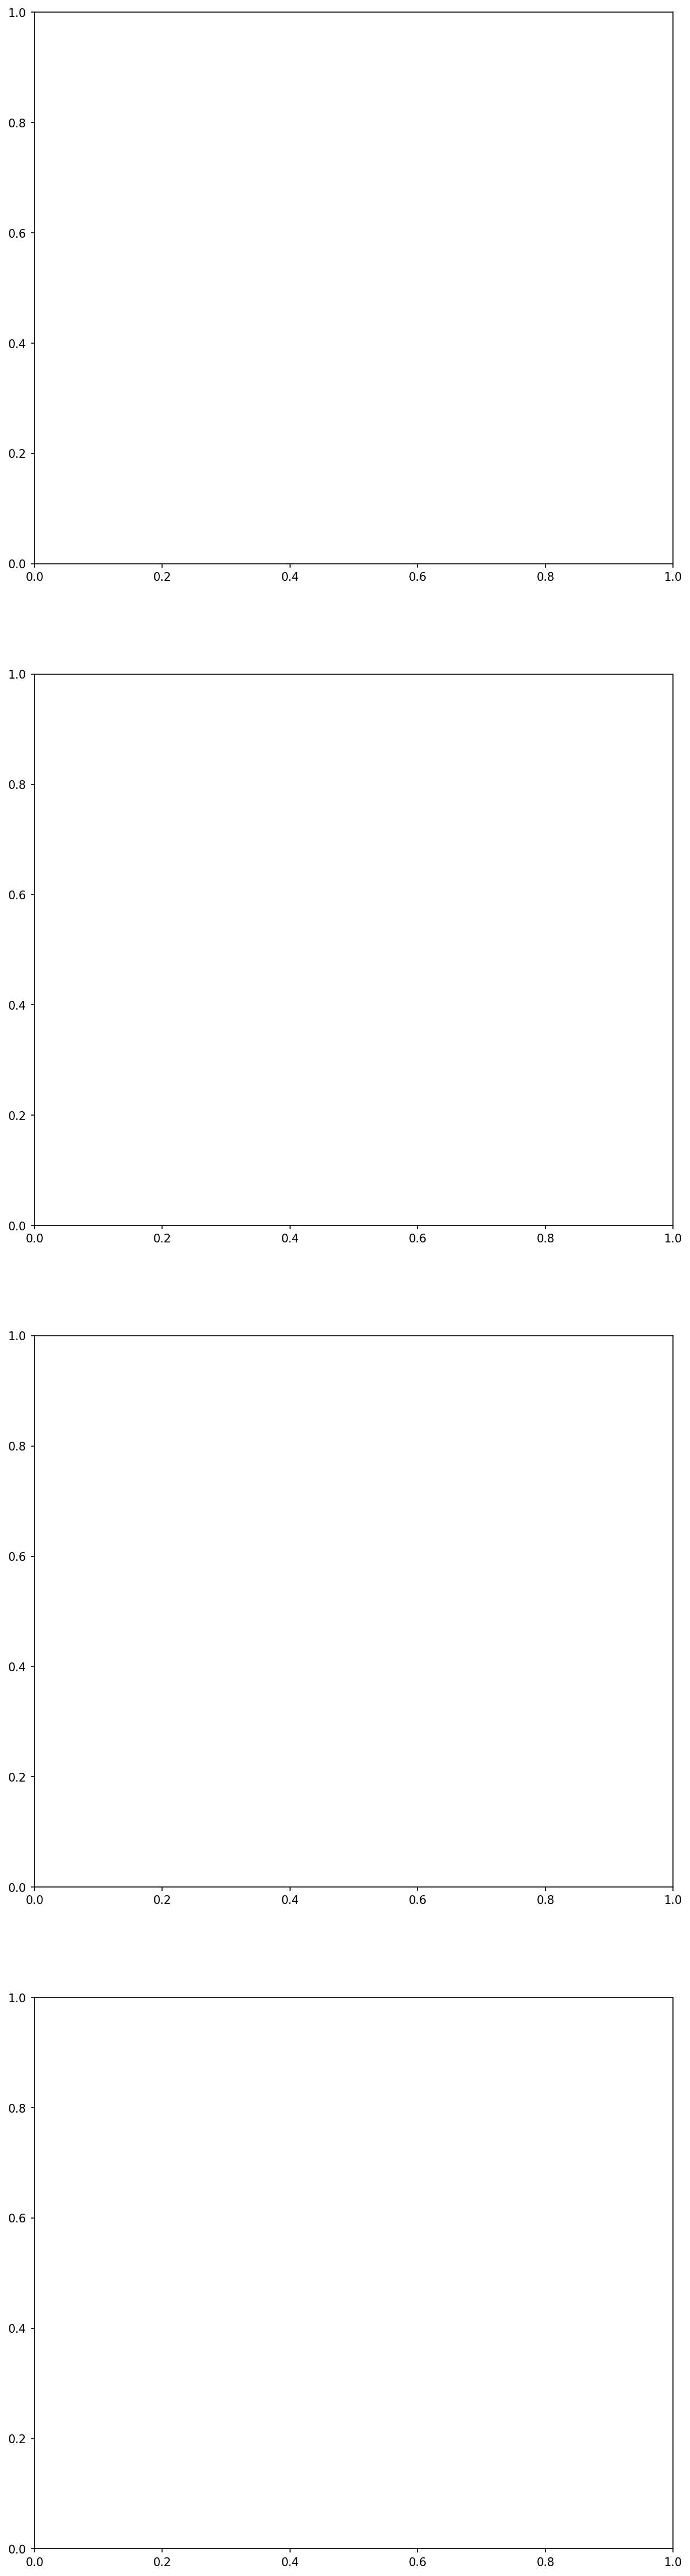

In [41]:
# csv to filtered plot

trim_display = [1,2, 3, 4]
vial_display = [4]

fig, axes = plt.subplots(len(trim_display), len(vial_display), figsize=(len(vial_display)*10, len(trim_display*10)), dpi = 150)
if (len(trim_display))==1: axes = [axes]
if (len(vial_display)) == 1:
    for i in range(trim_display):
        axes[i] = [axes[i]]
plt.suptitle(f"Filtered Tracking Plots for Trim {trim_display} Vial {vial_display}")

for t in range(len(trim_display)):
    v_num = 0
    for v in vial_display:
        d = pd.read_csv(f"./output/{name}_output/Set{set}_Trim{trim_display[t]}_Vial{v}_NewData.csv")
        md = pd.read_csv(f"./output/{name}_output/Set{set}_Trim{trim_display[t]}_Vial{v}_MetaData.csv")

        groups = [i for i in range(md.get("Fly Count")[0])]
        frames_in = [[] for i in range(md.get("Fly Count")[0])]

        axes[t][v_num].set_xticks(np.arange(0, md.get("Frame Count")[0], 20))
        axes[t][v_num].tick_params(axis = 'x', labelrotation = 90)

        for g in groups:
            column = d.get(f"Filtered {g+1}")
            column = [to_list(i) for i in column]

            for f in range(md.get("Frame Count")[0]):
                if column[f] != [-1, -1]:
                    frames_in[g].append(f)
            axes[t][v_num].scatter(
                [f_in for f_in in frames_in[g]],
                [column[f][0] for f in frames_in[g]],
                marker = ".",
                s = 2,
                c=colors[g],
            )
        v_num+=1

for x in range(len(axes[0])):
    axes[0][x].set_title(f"Vial {vial_display[x]}")
for x in range(len(axes)):
    axes[x][0].set_ylabel(f"Trim {trim_display[x]}", rotation=0, size='large')

plt.savefig(f"./output/{name}_output/NewFiltered_Plot_Trim{trim_display}_Vial{vial_display}.png")

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

set = 2
name = "Dev_Set2_W1118_CUT_Aug_20_2024"

In [19]:
def to_list(str):
    lis = str.strip("][").split(", ")
    ret = [eval(i) for i in lis]
    return ret;

colors = [
    "#2d6946", "#12db66", "#2fb8d4", "#557f87", "#2d4018",
    "#ff1100", "#561873", "#f7d872", "#5c2926","#878386",
    "#f7c10c", "#ff6e63", "#89e81c", "#678f39","#2d36ad",
    "#234e57", "#6066b5", "#9a60b5", "#d1288d", "#533278"
]

def get_distance(p1, p2):
    return ((((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2))**(0.5));

def find_mins(present, last, remember_ind):
    min_distance = []
    for p in range(len(present)): # First index is paired present location, second is old paired location
        min_dist = 9999
        index = -1
        if present[p] == [-1, -1]:
            continue;

        for l in range(len(last)):
            if (last[l] == [-1, -1]):
                continue;
            distance = get_distance(present[p], last[l])
            if (l in remember_ind): distance+=10
            
            if distance<min_dist:
                min_dist = distance
                index = l;
        min_distance.append([min_dist, p, index]) # minimum distance, present, old
    return min_distance

Yee


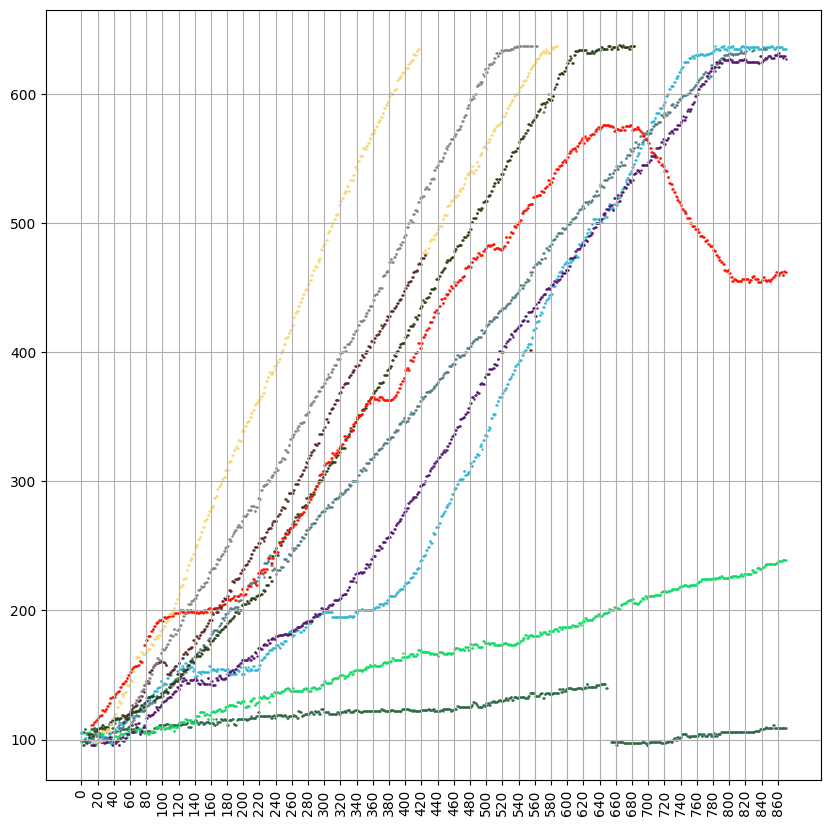

In [21]:
# For debugging the linking process
# Uses final tracking data from the csv and re-links points
def get_points_debug(s, t, v):
    setup_clc = pd.read_csv(f"./output/{name}_output/regular/Set{s}_Trim{t}_Vial{v}_Data.csv")
    setup_meta = pd.read_csv(f"./output/{name}_output/regular/Set{s}_Trim{t}_Vial{v}_MetaData.csv")
    clc = [[] for f in range(setup_meta["Frame Count"][0])]
    for g in range(setup_meta["Fly Count"][0]):
        for f in range(setup_meta["Frame Count"][0]):
            if setup_clc[f"Unfiltered {g+1}"][f]!='[-1, -1]':
                clc[f].append(to_list(setup_clc[f"Unfiltered {g+1}"][f]))

    points = [[]];
    stop=[420]
    n = setup_meta["Fly Count"][0]
    for g in range(len(clc[0])): # Put in first frame values
        points[0].append(clc[0][g]);
    for r in range(n-len(clc[0])):
        points[0].append([-1, -1]) # (-1, -1) = invalid, not in frame

    residuals = []

    found = len(clc[0])
    remember = [[-1, -1] for i in range(n)]

    for frame in range(1, len(clc)): # for each frame
        last = points[frame-1][:]
        present = clc[frame][:]

        remember_ind = [] # Adding remember into last and figuring out ind to take out
        for re in range(len(remember)):
            if remember[re] != [-1, -1]:
                remember_ind.append(re)
                # if last[re] != [-1, -1]:it's possible it's just rewriting the same remember from last frame
                last[re] = remember[re]

        positions = [[-1, -1] for i in range(n)]

        new_need = [i for i in range(len(present))] # New groups that need to be paired
        old_need = []                               # Old groups that need to be paired
        for i in range(len(last)):
            if last[i] != [-1, -1]:
                old_need.append(i)
                
        frame_residuals = []

        min_distance = sorted(find_mins(present, last, remember_ind)) # For each group: [min_dist, paired new index, closest old index]

        if (frame in stop):
            print("Yee")
            # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))
            # ax1.imshow(fg_bin[frame-1])
            # ax2.imshow(fg_bin[frame])
            # for t in range(len(min_distance)):
            #     ax1.plot([clc[frame-1][min_distance[t][2]][1],clc[frame][min_distance[t][1]][1]],[clc[frame-1][min_distance[t][2]][0],clc[frame][min_distance[t][1]][0]], marker = "+")
            # for t in range(len(lc[frame-1])):
            #     ax1.scatter([lc[frame-1][t][1]], [lc[frame-1][t][0]], s=1)
            # for t in range(len(lc[frame])):
            #     ax2.scatter([lc[frame][t][1]], [lc[frame][t][0]], s=1)

        for o in range(len(old_need)):
            if len(new_need)>0:
                if (min_distance[o][2] not in old_need or min_distance[o][1] not in new_need):
                    del min_distance[o:]
                    f_present = [[-1, -1] for i in present]
                    f_last = [[-1, -1] for i in last]
                    for ne in new_need:
                        f_present[ne] = present[ne]
                    for ol in old_need:
                        f_last[ol] = last[ol]
                    for item in sorted(find_mins(f_present, f_last, remember_ind)):
                        min_distance.append(item)

                positions[min_distance[o][2]] = present[min_distance[o][1]]
                frame_residuals.append(round(min_distance[o][0], 2))

                if min_distance[o][2] in remember_ind:
                    remember[min_distance[o][2]] = [-1, -1]
                old_need.remove(min_distance[o][2])
                new_need.remove(min_distance[o][1])
            else: # Should not get here before new, all new paired, old leftover and remember
                break;
        
        for ol in old_need:
            remember[ol] = last[ol]

        if (len(present)>found):
            old_found = found
            found = len(present)
            i = 0
            for ne in new_need:
                positions[old_found+i] = present[ne][:]
                i+=1;

        points.append(positions)
        residuals.append(frame_residuals)

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.set_xticks(np.arange(0, setup_meta["Frame Count"][0], 20))
    ax.tick_params(axis = 'x', labelrotation = 90)

    groups = [i for i in range(setup_meta["Fly Count"][0])]
    frames_in = [[] for i in range(setup_meta["Fly Count"][0])]
    for g in groups:
        for f in range(setup_meta["Frame Count"][0]):
                if (points[f][g]) != [-1, -1]:
                    frames_in[g].append(f)
        ax.scatter(
                [f_in for f_in in frames_in[g]],
                [setup_meta["y2"][0]-points[y][g][0] for y in frames_in[g]],
                marker = ".",
                s = 2,
                c=colors[g]
            )
    plt.grid()

get_points_debug(set, 2, 5)